# Phase Diagram of the Wilson-Cowan Model

Wilson, H., and Cowan, J. (1972). Excitatory and inhibitory interactions in localized populations of model neurons. _Biophysical Journal_ **12**. doi: [10.1016/S0006-3495(72)86068-5](https://doi.org/10.1016/S0006-3495(72)86068-5)

# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm
import sys
root_path = '/home/ec2-user/SageMaker/cascadia-behavioral-healthcare'
sys.path.insert(1, root_path + '/src')

##  Figure Settings


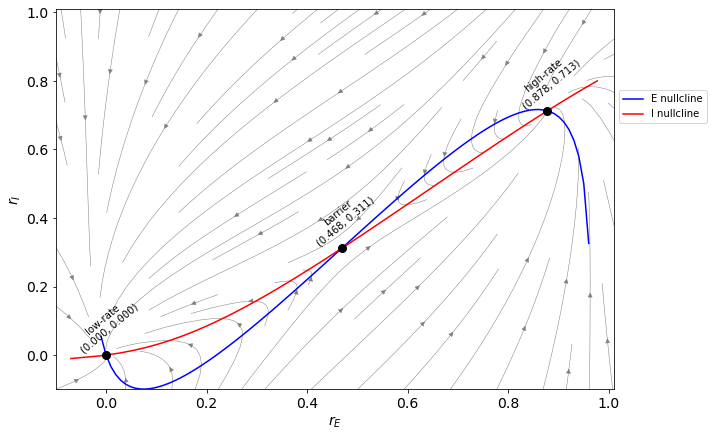

In [3]:
import neural_mech.neural_circuit as ncircuit
nc = ncircuit.Neural_Circuit()

def mod_plot_vector(pars, my_n_skip=2, myscale=5):
  EI_grid = np.linspace(-0.1, 1.1, 33)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = nc.EIderivs(rE, rI, **pars)
  n_skip = my_n_skip

  plt.streamplot(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             color='gray', linewidth=0.5, density=0.9)

  plt.xlabel('Excitatory Rate')
  plt.ylabel('Inhibitory Rate')

def plot_fp(x_fp, position=(0.02, 0.1), rotation=0, label='Fixed Point'):
  plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
  plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
           label+f'\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
           horizontalalignment='center', verticalalignment='bottom',
           rotation=rotation)
    
pars = nc.default_pars()

pars['wEE'] = 8.5
pars['wII'] = 9

# Compute nullclines
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-0.01, 0.8, 100)
Exc_null_rI = nc.get_E_nullcline(Exc_null_rE, **pars)
Inh_null_rE = nc.get_I_nullcline(Inh_null_rI, **pars)

fig = plt.figure(figsize=(10, 7.))
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
mod_plot_vector(pars)

nc.plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI)

# Find the correct fixed point
x_fp_1 = nc.find_fp(pars, 0.8, 0.6)
plot_fp(x_fp_1, position=(0, 0), rotation=40, label='high-rate')

x_fp_2 = nc.find_fp(pars, 0.0, 0.0)
plot_fp(x_fp_2, position=(0, 0), rotation=40, label='low-rate')

x_fp_3 = nc.find_fp(pars, 0.3, 0.2)
plot_fp(x_fp_3, position=(0, 0), rotation=40, label='barrier')


plt.legend(loc=[1.01, 0.7])
plt.xlim(-0.1, 1.01)
plt.ylim(-0.1, 1.01);
# fig.savefig('./figs_publ/phase_plane.tiff', dpi=300, format="tiff")

## Short pulse induced persistent activity
Use a brief 10-ms positive current to the E population when the system is at its equilibrium. When this amplitude (SE below) is sufficiently large, a persistent activity is produced that outlasts the transient input. What is the firing rate of the persistent activity, and what is the critical input strength? Try to understand the phenomena from the above phase-plane analysis.

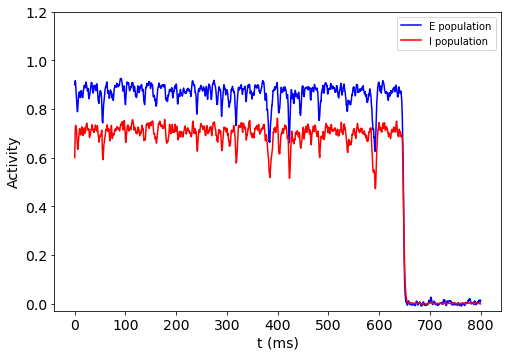

In [136]:
def my_OU(pars, sig, myseed=False):
    """
    Generates Ornstein-Uhlenbeck input current
      pars       : parameter dictionary
      sig        : noise amplitute
      myseed     : random seed. int or boolean
      I_ou       : Ornstein-Uhlenbeck input current
    """
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tau_ou = pars['tau_ou']  # [ms]
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()
    # Initialize
    noise = np.random.randn(Lt)
    I_ou = np.zeros(Lt)
    I_ou[0] = noise[0] * sig
    # generate OU
    for it in range(Lt-1):
        I_ou[it+1] = (I_ou[it]
                    + dt / tau_ou * (0. - I_ou[it])
                    + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1])
    return I_ou

def simulate_wc(tau1, a_1, theta_1, tau0, a_0, theta_0,
                w11, w10, w01, w00, I_ext_1, I_ext_0,
                r1_init, r0_init, dt, range_t):
    """
    Simulate the Wilson-Cowan equations
    Args: WC parameters
    Returns: rE, rI (arrays) : Activity of excitatory and inhibitory populations
    """
    # Initialize activity arrays
    Lt = range_t.size
    r1 = np.append(r1_init, np.zeros(Lt - 1))
    r0 = np.append(r0_init, np.zeros(Lt - 1))
    I_ext_1 = I_ext_1 * np.ones(Lt)
    I_ext_0 = I_ext_0 * np.ones(Lt)

    # Simulate the Wilson-Cowan equations
    for k in range(Lt - 1):
        # Calculate the derivative of the E population
        dr1 = dt / tau1 * (-r1[k] + nc.f(w11 * r1[k] - w10 * r0[k] + I_ext_1[k],
                                       a_1, theta_1))
        # Calculate the derivative of the I population
        dr0 = dt / tau0 * (-r0[k] + nc.f(w01 * r1[k] - w00 * r0[k] + I_ext_0[k],
                                   a_0, theta_0))
        # Update using Euler's method
        r1[k + 1] = r1[k] + dr1
        r0[k + 1] = r0[k] + dr0
    return r1, r0

def WC_with_pulse(SE=0.):
    pars['I_ext_1'] = my_OU(pars, sig=sig_ou, myseed=42)
    rE, rI = simulate_wc(pars['tau1'], pars['mu1'], pars['th1'], 
                       pars['tau_0'], pars['mu0'], pars['th0'],
                       pars['w11'], pars['w10'], pars['w01'], pars['w00'], 
                       pars['I_ext_1'], pars['I_ext_0'],
                       pars['r1_init'], pars['r0_init'], pars['dt'], pars['range_t'])
    fig = plt.figure(figsize=(8, 5.5))
    ax = plt.subplot(111)
    ax.plot(pars['range_t'], rE, 'b', label='E population')
    ax.plot(pars['range_t'], rI, 'r', label='I population')
    ax.set_ylim(-0.03, 1.2)
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('Activity')
    ax.legend(loc='best')

pars = nc.default_pars()
pars['range_t'] = np.arange(0, 800, 0.1)  #Adjust duration of the simulation
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.19
pars['I_ext_0'] = my_OU(pars, sig=sig_ou, myseed=2021)
pars['r1_init'], pars['r0_init'] = 0.9, 0.6
WC_with_pulse(SE=(0.0, 1.0, .05))
# fig.savefig('./figs_publ/activity_burst.tiff', dpi=300, format="tiff")